# Dataset Analysis

This notebook contains my analysis of the datasets v1 and v2. It was used to discover the differences between the two datasets.

## Background

During my initial test runs of training, the performance of the model trained on v1 was better than the one trained on v2. However, the size of v2 was larger than v1, roughly 2x. Therefore, I would like to understand the differences between the two datasets and what might lead to such performance differences. Mainly, I am focusing on the following factors:

- Quality
    - Success rate/reward
    - Smoothness of trajectories
- Size
    - Number of episodes
    - Length of each episode

If there are no significant differences in these factors, then maybe the test runs were too short to utilize the full potential of the datasets.

## Preparations


In [ ]:
import os
import base64
from typing import Optional, Sequence

import zarr
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tabulate
from IPython.display import HTML
from shapely import geometry
from shapely import affinity
from tqdm import tqdm



Be sure to download and extract the dataset under `diffusion_pusht/data/pusht`.

In [2]:
data_v1 = zarr.open_group("../../data/pusht/pusht_cchi_v1.zarr")
data_v2 = zarr.open_group("../../data/pusht/pusht_cchi_v2.zarr/")

## Finding Identicals

First of, I would like to find out whether there are any overlaps between the two datasets. This is done in a rather brute-force way: by comparing the images/videos of the two datasets. If the visualizations are identical, then it can be concluded that the episodes are identical.


In [3]:
def get_length(data) -> int:
    return len(data["meta"]["episode_ends"][:].tolist())


def get_element_by_idx(data, key: str, idx: int):
    if idx >= get_length(data):
        raise IndexError
    episode_ends = data["meta"]["episode_ends"][:].tolist()
    start = 0 if idx == 0 else episode_ends[idx - 1]
    end = episode_ends[idx]
    return data["data"][key][start:end]


def get_video_by_idx(data, idx: int):
    return np.array(get_element_by_idx(data, "img", idx), dtype=np.uint8)


def get_identical_indices(data_v1, data_v2):
    """Find out which episode in v2 corresponds to v1."""
    v2_idx_set = set(range(get_length(data_v2)))
    v1_to_v2 = {}

    for i in range(get_length(data_v1)):
        imgs1 = get_video_by_idx(data_v1, i)
        for j in v2_idx_set:
            imgs2 = get_video_by_idx(data_v2, j)
            if imgs1.shape[0] != imgs2.shape[0]:
                continue
            diff = np.abs(imgs1 - imgs2).sum()
            if diff == 0:
                v1_to_v2.update({i: j})
                v2_idx_set.remove(j)
                break
    return v1_to_v2


v1_to_v2 = get_identical_indices(data_v1, data_v2)
v2_exclusives = set(range(get_length(data_v2))) - set(v1_to_v2.values())

print(f"Number of identical episodes: {len(v1_to_v2)}")
print(f"Ratio of identical episodes: {len(v1_to_v2) / get_length(data_v1) * 100:.0f}%")


Number of identical episodes: 103
Ratio of identical episodes: 100%


Seems like v1 is a subset of v2!

Now that v2 is an extension of v1, I wanted to see if the additional episodes in v2 share the same initial states as v1. If the initial states are identical, it might be easier to assess the quality of the two datasets.


In [4]:
def match_identical_initial_state(data_v1, data_v2):
    """Find out whether there are identical initial states."""
    matches = []
    for i in range(get_length(data_v1)):
        curr = set()
        s1 = get_element_by_idx(data_v1, "state", i)[0, :]
        for j in range(get_length(data_v2)):
            s2 = get_element_by_idx(data_v2, "state", j)[0, :]
            if (s1 == s2).all():
                curr.add(j)
        matches.append(curr)
    return matches

init_cond_matches = match_identical_initial_state(data_v1, data_v2)

if any(len(matches) > 1 for matches in init_cond_matches):
    print("There are identical initial states in v2.")
else:
    print("No identical initial states in v2 are found.")


No identical initial states in v2 are found.


## Quality Analysis

Next, I would like to assess the quality of the two datasets by computing the reward and success rate of the episodes.

According to the original repository, whether an episode is successful is determined by the intersection of the goal pose and the current pose. If the overlapping area reaches a threshold (95% in this case), the episode is considered successful. The definition of reward is similar. It is the ratio of the overlapping area, but divided by the success threshold and clipped to 0-1. In other words, once the overlapping area reaches 95%, the reward reaches its maximum, and the model is allowed to terminate.

Here, the average of the maximum rewards of each episode within both datasets are calculated, along with the corresponding success rates. In addition, I isolated the v2-exclusive episodes to get a clearer picture.


In [5]:
GOAL_POSE = np.array([256, 256, np.pi / 4])
LENGTH = 4
SCALE = 30
SUCCESS_THRESHOLD = 0.95


def get_tee(position: tuple[float, float], angle: float):
    """Adopted from diffusion_policy source code."""
    tee = geometry.Polygon([
        (-LENGTH * SCALE / 2, 0),
        (-LENGTH * SCALE / 2, SCALE),
        (-SCALE / 2, SCALE),
        (-SCALE / 2, SCALE * LENGTH),
        (SCALE / 2, SCALE * LENGTH),
        (SCALE / 2, SCALE),
        (LENGTH * SCALE / 2, SCALE),
        (LENGTH * SCALE / 2, 0),
        (0, 0),
    ])

    return affinity.translate(
        affinity.rotate(tee, angle, origin=(0,0), use_radians=True),
        position[0],
        position[1]
    )


def get_goal():
    return get_tee((256, 256), np.pi / 4)


def get_metric(data, idx: int):
    goal = get_goal()
    goal_area = goal.area
    states = get_element_by_idx(data, "state", idx)
    max_reward = 0
    max_converage = 0
    for state in states:
        curr = get_tee((state[2], state[3]), state[4])
        intersect = goal.intersection(curr).area
        coverage = intersect / goal_area
        reward = np.clip(coverage / SUCCESS_THRESHOLD, 0, 1)
        max_reward = max(max_reward, reward)
        max_converage = max(max_converage, coverage)

    is_success = (max_converage >= SUCCESS_THRESHOLD)

    return max_reward, is_success


def get_mean_metrics(data, indices: Optional[Sequence[int]] = None):
    total_reward = 0
    total_success = 0
    if indices is None:
        indices = list(range(get_length(data)))

    for i in indices:
        reward, is_success = get_metric(data, i)
        total_reward += reward
        if is_success:
            total_success += 1

    return total_reward / len(indices), total_success / len(indices)

reward_v1, success_rate_v1 = get_mean_metrics(data_v1)
reward_v2, success_rate_v2 = get_mean_metrics(data_v2)
reward_v2_exclusive, success_rate_v2_exclusive = get_mean_metrics(data_v2, v2_exclusives)

print(
    tabulate.tabulate(
        [
            ["v1", reward_v1, success_rate_v1],
            ["v2", reward_v2, success_rate_v2],
            ["v2_exclusive", reward_v2_exclusive, success_rate_v2_exclusive],
        ],
        headers=["Dataset", "Mean Reward", "Success Rate"],
        tablefmt="github",
    )
)


| Dataset      |   Mean Reward |   Success Rate |
|--------------|---------------|----------------|
| v1           |      0.893062 |              0 |
| v2           |      0.8923   |              0 |
| v2_exclusive |      0.891538 |              0 |


Below is a visualization of the current & goal poses to ensure that the calculations are valid.

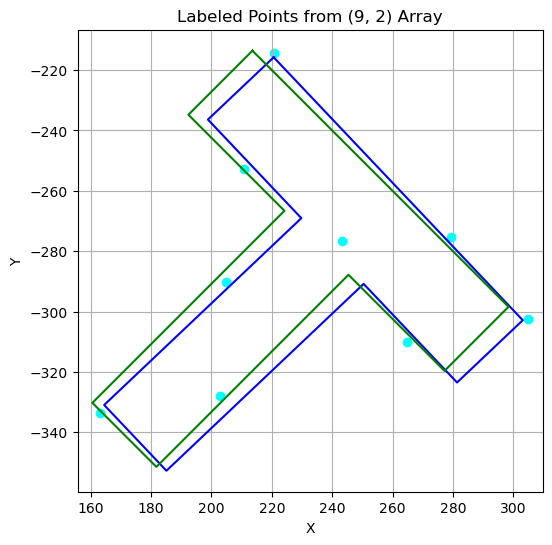

In [6]:
def plot_kp(points, goal, kp):
    # Plot the points
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], -points[:, 1], color='blue')
    plt.plot(goal[:, 0], -goal[:, 1], color="green")
    plt.scatter(kp[:, 0], -kp[:, 1], color="cyan")

    plt.title("Labeled Points from (9, 2) Array")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')  # Keep aspect ratio equal for better visualization
    plt.show()


states = get_element_by_idx(data_v1, "state", 0)
state = states[-1]
curr = get_tee((state[2], state[3]), state[4])
kp = get_element_by_idx(data_v1, "keypoint", 0)[-1]
plot_kp(np.array(curr.exterior.coords), np.array(get_goal().exterior.coords), kp)

## Visualization

Last but not least, I would like to visualize the trajectories of the two datasets.


In [7]:
def generate_videos(data, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    prev = 0
    episode_ends = data["meta"]["episode_ends"][:]
    for i in tqdm(range(episode_ends.shape[0])):
        curr = int(episode_ends[i])
        imgs = data["data"]["img"][prev:curr]
        imgs = np.array(imgs, dtype=np.uint8)
        imageio.mimsave(os.path.join(output_dir, f"gt_{i}.gif"), imgs, fps=30)
        prev = curr


generate_videos(data_v1, "../../data/data_v1_videos")
generate_videos(data_v2, "../../data/data_v2_videos")


100%|██████████| 206/206 [00:32<00:00,  6.37it/s]


In [ ]:
def gif_to_base64(gif_path):
    """Convert GIF to base64 string"""
    try:
        with open(gif_path, "rb") as f:
            return base64.b64encode(f.read()).decode()
    except FileNotFoundError:
        print(f"Warning: {gif_path} not found")
        return None


def display_embedded_gif_matrix(gif_paths, rows, cols):
    """
    Display GIFs embedded as base64.
    """
    html_content = """
    <div class="gif-matrix" style="text-align: center;">
    <style>
    .gif-matrix table { margin: 0 auto; border-collapse: collapse; }
    .gif-matrix td { padding: 10px; text-align: center; }
    .gif-matrix img { border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1); }
    </style>
    <table>
    """

    for i in range(rows):
        html_content += "<tr>"
        for j in range(cols):
            idx = i * cols + j
            if idx < len(gif_paths):
                b64_gif = gif_to_base64(gif_paths[idx])
                if b64_gif:
                    html_content += f'''
                    <td>
                        <img src="data:image/gif;base64,{b64_gif}"
                             style="width:200px;height:200px;"
                             alt="Animation {idx+1}">
                    </td>
                    '''
                else:
                    html_content += '<td><div style="width:200px;height:200px;background:#f0f0f0;"></div></td>'
            else:
                html_content += '<td></td>'
        html_content += "</tr>"

    html_content += "</table></div>"
    return HTML(html_content)


def get_gifs(path: str, indices: Optional[Sequence[int]] = None) -> list[str]:
    all_gifs = sorted(os.path.join(path, gif) for gif in os.listdir(path) if gif.endswith(".gif"))
    if indices is None:
        indices = set(range(len(all_gifs)))
    else:
        indices = set(indices)

    output = []
    for i, f in enumerate(all_gifs):
        if i not in indices:
            continue
        output.append(f)

    return output



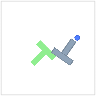
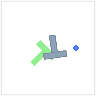
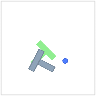
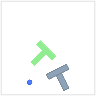
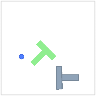
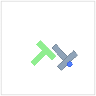
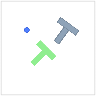
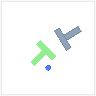
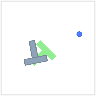

In [9]:
display_embedded_gif_matrix(get_gifs("data_analysis/assets/data_v1_videos")[:9], 3, 3)


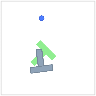
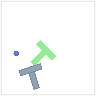
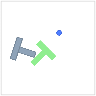
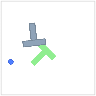
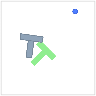
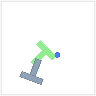
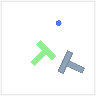
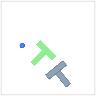
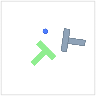

In [10]:
display_embedded_gif_matrix(get_gifs("data_analysis/assets/data_v2_videos")[:9], 3, 3)